In [2]:
import argparse
import random
import numpy as np
from habitat_baselines.config.default import get_config
import habitat
import os
from habitat import Config, logger
from habitat import Config, Dataset
import matplotlib.pyplot as plt
import transformations as tf
import quaternion
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
import contextlib
import time
from collections import OrderedDict, defaultdict, deque
from typing import Any, Dict, List, Optional
from habitat_baselines.rl.ddppo.algo.ddp_utils import (
    EXIT,
    REQUEUE,
    add_signal_handlers,
    init_distrib_slurm,
    load_interrupted_state,
    requeue_job,
    save_interrupted_state,
)
from habitat_baselines.common.baseline_registry import baseline_registry
#from habitat_baselines.common.env_utils import construct_envs
from habitat_baselines.common.environments import get_env_class
from habitat_baselines.common.rollout_storage import RolloutStorage
from habitat_baselines.common.tensorboard_utils import TensorboardWriter
from habitat_baselines.common.utils import batch_obs, linear_decay
import numpy as np
import torch
import torch.distributed as distrib
import torch.nn as nn
from gym import spaces
from gym.spaces.dict_space import Dict as SpaceDict
from torch.optim.lr_scheduler import LambdaLR
from resnet_policy import PointNavResNetPolicy
from habitat_baselines.rl.ddppo.algo.ddppo import DDPPO
from habitat_baselines.common.base_trainer import BaseRLTrainer
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower

In [4]:
from ppotrainer import PPOTrainer
from ddpotrainer import DDPPOTrainer
from constructenv import construct_envs
from env import MyRLEnvNew
from habitat import make_dataset
from constructenv import make_env_fn
from vectorenv import VectorEnv
from utils import FrameSkip, FrameStack, draw_top_down_map
from arguments import get_args

# Config init

In [5]:
import fileinput
filename = "/habitat-api/habitat_baselines/config/pointnav/ddppo_pointnav.yaml"
with fileinput.FileInput(filename, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace('\"configs/tasks/pointnav_gibson.yaml\"', '\"/habitat-api/configs/tasks/pointnav_gibson.yaml\"'), end='')
with fileinput.FileInput(filename, inplace=True, backup='.bak') as file:        
    for line in file:    
        print(line.replace('GLOO', 'NCCL'), end='')

In [6]:
W = 256#640
H = 256#360
config_paths="/data/challenge_pointnav2020.local.rgbd.yaml"
config = habitat.get_config(config_paths=config_paths)
config.defrost()
config.SIMULATOR.RGB_SENSOR.HEIGHT = H
config.SIMULATOR.RGB_SENSOR.WIDTH = W
config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
config.DATASET.DATA_PATH = '/data/v1/{split}/{split}.json.gz'
config.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config.TASK.SENSORS = ["HEADING_SENSOR", "COMPASS_SENSOR", "GPS_SENSOR", "POINTGOAL_SENSOR", "POINTGOAL_WITH_GPS_COMPASS_SENSOR"]
config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.DIMENSIONALITY = 3
config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.GOAL_FORMAT = "CARTESIAN"
config.TASK.POINTGOAL_SENSOR.DIMENSIONALITY = 3
config.TASK.POINTGOAL_SENSOR.GOAL_FORMAT = "CARTESIAN"
config.TASK.GPS_SENSOR.DIMENSIONALITY = 3
config.TASK.GPS_SENSOR.GOAL_FORMAT = "CARTESIAN"
config.TASK.AGENT_POSITION_SENSOR = habitat.Config()
config.TASK.AGENT_POSITION_SENSOR.TYPE = "position_sensor"
config.TASK.AGENT_POSITION_SENSOR.ANSWER_TO_LIFE = 42
config.TASK.SENSORS.append("AGENT_POSITION_SENSOR")
config.SIMULATOR.TURN_ANGLE = 10#0.5
config.SIMULATOR.TILT_ANGLE = 10#0.5
config.SIMULATOR.FORWARD_STEP_SIZE = 0.25#0.0125
config.ENVIRONMENT.MAX_EPISODE_STEPS = 500#*20
config.TASK.TOP_DOWN_MAP.MAX_EPISODE_STEPS = 500#*20
config.DATASET.SCENES_DIR = '/data'
config.DATASET.SPLIT = 'val'
config.SIMULATOR.SCENE = '/data/gibson/Aldrich.glb'
#config.SIMULATOR_GPU_ID = 0
config.freeze()

In [7]:
config2 = get_config('/habitat-api/habitat_baselines/config/pointnav/ddppo_pointnav.yaml', [])
ii = 0
for i in config2.TASK_CONFIG.keys():
    config2.TASK_CONFIG[i] = config[i]
    ii+=1
config = config2    

In [8]:
config.defrost()
config.TASK_CONFIG.DATASET.DATA_PATH = '/data/v1/{split}/{split}.json.gz'
config.TASK_CONFIG.DATASET.SCENES_DIR = '/data'
config.TASK_CONFIG.DATASET.SPLIT = 'val'
config.TASK_CONFIG.SIMULATOR.SCENE = '/data/gibson/Aldrich.glb'
config.TASK_CONFIG.TASK.GOAL_SENSOR_UUID = 'pos'#'pointgoal_with_gps_compass'
config.NUM_UPDATES = 50000
config.ENV_NAME = 'MyRLEnvNew'
config.NUM_PROCESSES = 30
config.RL.FRAMESKIP = 1
config.RL.FRAMESTACK = 1
config.freeze()

In [9]:
argumnts = ''
args = get_args(argumnts)
device = args.device = torch.device("cuda:0" if args.cuda else "cpu")
args.num_processes = 1

Auto GPU config:
Number of processes: 9
Number of processes on GPU 0: 9
Number of processes per GPU: 0


# Test env

In [7]:
from typing import Any, Dict, Iterator, List, Optional, Tuple, Type, Union
from gym.spaces.dict_space import Dict as SpaceDict
from habitat.config import Config
from habitat.core.dataset import Dataset, Episode, EpisodeIterator
from habitat.core.embodied_task import EmbodiedTask, Metrics
from habitat.core.simulator import Observations, Simulator
from habitat.datasets import make_dataset
from habitat.sims import make_sim
from habitat.tasks import make_task
from collections import OrderedDict, defaultdict, deque
import gym
import numba

In [8]:
class Env:

    observation_space: SpaceDict
    action_space: SpaceDict
    _config: Config
    _dataset: Optional[Dataset]
    number_of_episodes: Optional[int]
    _episodes: List[Type[Episode]]
    _current_episode_index: Optional[int]
    _current_episode: Optional[Type[Episode]]
    _episode_iterator: Optional[Iterator]
    _sim: Simulator
    _task: EmbodiedTask
    _max_episode_seconds: int
    _max_episode_steps: int
    _elapsed_steps: int
    _episode_start_time: Optional[float]
    _episode_over: bool

    def __init__(
        self, config: Config, dataset: Optional[Dataset] = None
    ) -> None:

        assert config.is_frozen(), (
            "Freeze the config before creating the "
            "environment, use config.freeze().")
        self._config = config
        self._dataset = dataset
        self._current_episode_index = None
        if self._dataset is None and config.DATASET.TYPE:
            self._dataset = make_dataset(
                id_dataset=config.DATASET.TYPE, config=config.DATASET
            )
        self._episodes = self._dataset.episodes if self._dataset else []
        self._current_episode = None
        iter_option_dict = {
            k.lower(): v
            for k, v in config.ENVIRONMENT.ITERATOR_OPTIONS.items()
        }
        self._episode_iterator = self._dataset.get_episode_iterator(
            **iter_option_dict
        )

        # load the first scene if dataset is present
        if self._dataset:
            assert (
                len(self._dataset.episodes) > 0
            ), "dataset should have non-empty episodes list"
            self._config.defrost()
            self._config.SIMULATOR.SCENE = self._dataset.episodes[0].scene_id
            self._config.freeze()

            self.number_of_episodes = len(self._dataset.episodes)
        else:
            self.number_of_episodes = None

        self._sim = make_sim(
            id_sim=self._config.SIMULATOR.TYPE, config=self._config.SIMULATOR)
        self.follower = ShortestPathFollower(self._sim, 0.36, False)
        self._task = make_task(
            self._config.TASK.TYPE,
            config=self._config.TASK,
            sim=self._sim,
            dataset=self._dataset)
        self.observation_space = SpaceDict(
            {
                **self._sim.sensor_suite.observation_spaces.spaces,
                **self._task.sensor_suite.observation_spaces.spaces,
            })
        self.action_space = self._task.action_space
        self._max_episode_seconds = (
            self._config.ENVIRONMENT.MAX_EPISODE_SECONDS)
        self._max_episode_steps = self._config.ENVIRONMENT.MAX_EPISODE_STEPS
        self._elapsed_steps = 0
        self._episode_start_time: Optional[float] = None
        self._episode_over = False

    @property
    def current_episode(self) -> Type[Episode]:
        assert self._current_episode is not None
        return self._current_episode

    @current_episode.setter
    def current_episode(self, episode: Type[Episode]) -> None:
        self._current_episode = episode

    @property
    def episode_iterator(self) -> Iterator:
        return self._episode_iterator

    @episode_iterator.setter
    def episode_iterator(self, new_iter: Iterator) -> None:
        self._episode_iterator = new_iter

    @property
    def episodes(self) -> List[Type[Episode]]:
        return self._episodes

    @episodes.setter
    def episodes(self, episodes: List[Type[Episode]]) -> None:
        assert (
            len(episodes) > 0
        ), "Environment doesn't accept empty episodes list."
        self._episodes = episodes

    @property
    def sim(self) -> Simulator:
        return self._sim

    @property
    def episode_start_time(self) -> Optional[float]:
        return self._episode_start_time

    @property
    def episode_over(self) -> bool:
        return self._episode_over

    @property
    def task(self) -> EmbodiedTask:
        return self._task

    @property
    def _elapsed_seconds(self) -> float:
        assert (
            self._episode_start_time
        ), "Elapsed seconds requested before episode was started."
        return time.time() - self._episode_start_time

    def get_metrics(self) -> Metrics:
        return self._task.measurements.get_metrics()

    def _past_limit(self) -> bool:
        if (
            self._max_episode_steps != 0
            and self._max_episode_steps <= self._elapsed_steps
        ):
            return True
        elif (
            self._max_episode_seconds != 0
            and self._max_episode_seconds <= self._elapsed_seconds
        ):
            return True
        return False

    def _reset_stats(self) -> None:
        self._episode_start_time = time.time()
        self._elapsed_steps = 0
        self._episode_over = False

    def reset(self) -> Observations:
        r"""Resets the environments and returns the initial observations.
        :return: initial observations from the environment.
        """
        self._reset_stats()
        
        self.map_size_cm = 2400
        self.curr_loc = [self.map_size_cm/100.0/2.0,
                         self.map_size_cm/100.0/2.0, 0.]
        self.last_sim_location = self.get_sim_location()
        self.trux = 0; self.truy = 0; self.truz = 0
        
        assert len(self.episodes) > 0, "Episodes list is empty"
        if self._current_episode is not None:
            self._current_episode._shortest_path_cache = None

        # Delete the shortest path cache of the current episode
        # Caching it for the next time we see this episode isn't really worth
        # it
        if self._current_episode is not None:
            self._current_episode._shortest_path_cache = None

        self._current_episode = next(self._episode_iterator)
        self.reconfigure(self._config)

        observations = self.task.reset(episode=self.current_episode)
        self.goal = observations['pointgoal']
        observations['real_pos'] = [self.trux,self.truy]
        self._task.measurements.reset_measures(
            episode=self.current_episode, task=self.task)

        return observations

    def _update_step_stats(self) -> None:
        self._elapsed_steps += 1
        self._episode_over = not self._task.is_episode_active
        if self._past_limit():
            self._episode_over = True

        if self.episode_iterator is not None and isinstance(
            self.episode_iterator, EpisodeIterator):
            self.episode_iterator.step_taken()

    def step(
        self, action: Union[int, str, Dict[str, Any]], **kwargs) -> Observations:

        gl = np.array(list(self.goal)+[0.])
        frf = np.copy(gl[1])
        gl[1]=gl[2]
        gl[2]=frf
        print(gl)
        best_action = self.follower.get_next_action(gl)
        assert (
            self._episode_start_time is not None
        ), "Cannot call step before calling reset"
        assert (
            self._episode_over is False
        ), "Episode over, call reset before calling step"
        # Support simpler interface as well
        if isinstance(action, str) or isinstance(action, (int, np.integer)):
            action = {"action": best_action}#action}
            
        
        observations = self.task.step(action=action, episode=self.current_episode)
        
        dx_gt, dy_gt, do_gt = self.get_gt_pose_change()
        self.curr_loc = pu.get_new_pose(self.curr_loc,
                               (dx_gt, dy_gt, do_gt))
        self.trux = self.curr_loc[0]-12
        self.truy = self.curr_loc[1]-12
        
        observations['real_pos'] = [self.trux,self.truy]

        self._task.measurements.update_measures(
            episode=self.current_episode, action=action, task=self.task)
        self._update_step_stats()
        return observations

    @staticmethod
    @numba.njit
    def _seed_numba(seed: int):
        random.seed(seed)
        np.random.seed(seed)

    def seed(self, seed: int) -> None:
        random.seed(seed)
        np.random.seed(seed)
        self._seed_numba(seed)
        self._sim.seed(seed)
        self._task.seed(seed)

    def reconfigure(self, config: Config) -> None:
        self._config = config
        self._config.defrost()
        self._config.SIMULATOR = self._task.overwrite_sim_config(
            self._config.SIMULATOR, self.current_episode)
        self._config.freeze()
        self._sim.reconfigure(self._config.SIMULATOR)

    def render(self, mode="rgb") -> np.ndarray:
        return self._sim.render(mode)

    def close(self) -> None:
        self._sim.close()
        
    def get_sim_location(self):
        agent_state = self._sim.get_agent_state(0)
        x = -agent_state.position[2]
        y = -agent_state.position[0]
        axis = quaternion.as_euler_angles(agent_state.rotation)[0]
        if (axis%(2*np.pi)) < 0.1 or (axis%(2*np.pi)) > 2*np.pi - 0.1:
            o = quaternion.as_euler_angles(agent_state.rotation)[1]
        else:
            o = 2*np.pi - quaternion.as_euler_angles(agent_state.rotation)[1]
        if o > np.pi:
            o -= 2 * np.pi
        return x, y, o
    
    def get_gt_pose_change(self):
        curr_sim_pose = self.get_sim_location()
        dx, dy, do = pu.get_rel_pose_change(curr_sim_pose, self.last_sim_location)
        self.last_sim_location = curr_sim_pose
        return dx, dy, do

In [9]:
env = Env(config=config)

2020-05-16 16:57:22,620 Initializing dataset PointNav-v1
2020-05-16 16:57:22,637 initializing sim Sim-v0
2020-05-16 16:57:28,570 Initializing task Nav-v0


In [11]:
obs  = env.reset()

In [17]:
env._current_episode.goals[0].position

[-11.20059, 0.15825, -4.1339]

In [ ]:
env.habitat_env.current_episode.goals[0].position

In [14]:
env._current_episode

NavigationEpisode(episode_id=1, scene_id='/data/gibson/Cantwell.glb', start_position=[-0.27251, 0.15825, -1.17589], start_rotation=[0, 0.95258, 0, -0.30428], info={'geodesic_distance': 12.50322}, goals=[NavigationGoal(position=[-11.20059, 0.15825, -4.1339], radius=None)], start_room=None, shortest_paths=None)

## Construct one env (example)

In [10]:
print(config.ENV_NAME)
env_class = get_env_class(config.ENV_NAME)
dataset = make_dataset(config.TASK_CONFIG.DATASET.TYPE, config=config.TASK_CONFIG.DATASET)
one_env = env_class(config=config, dataset=dataset)

2020-05-14 19:41:18,314 Initializing dataset PointNav-v1
2020-05-14 19:41:18,339 initializing sim Sim-v0


MyRLEnvNew


2020-05-14 19:41:24,518 Initializing task Nav-v0


In [11]:
goal_radius = config.TASK_CONFIG.SIMULATOR.FORWARD_STEP_SIZE
follower = ShortestPathFollower(one_env.habitat_env.sim, goal_radius, False)

In [16]:
one_env.habitat_env.current_episode.goals[0].position

[-13.14364, 0.15825, -5.08375]

In [23]:
one_env.habitat_env.current_episode.goals[0].position

[-13.14364, 0.15825, -5.08375]

In [26]:
one_env.habitat_env.current_episode.start_position

[-4.69643, 0.15825, -2.90618]

In [20]:
obs['pos']

array([-3.6716154 , -3.19518046])

In [12]:
actor_critic = PointNavResNetPolicy(
            observation_space=one_env.observation_space,
            action_space=one_env.action_space,
            hidden_size=config.RL.PPO.hidden_size,
            rnn_type=config.RL.DDPPO.rnn_type,
            num_recurrent_layers=config.RL.DDPPO.num_recurrent_layers,
            backbone=config.RL.DDPPO.backbone,
            goal_sensor_uuid=config.TASK_CONFIG.TASK.GOAL_SENSOR_UUID,
            normalize_visual_inputs=False,
        )
actor_critic.to(device);

In [13]:
pretrained_state = torch.load('ckpt.143.pth', map_location="cpu")
actor_critic.load_state_dict({k[len("actor_critic.") :]: v for k, v in pretrained_state["state_dict"].items() if "actor_critic" in k})

<All keys matched successfully>

In [14]:
obs_space = one_env.observation_space
ppo_cfg = config.RL.PPO

In [15]:
obs = one_env.reset()
r = 0
rollouts = RolloutStorage(
            500,
            1,
            obs_space,
            one_env.action_space,
            ppo_cfg.hidden_size,
            num_recurrent_layers=actor_critic.net.num_recurrent_layers)
rollouts.to(device)
batch = batch_obs([obs])
for sensor in rollouts.observations:
    rollouts.observations[sensor][0].copy_(batch[sensor])

0.06469511985778809
Pointgoal 	 [4.25462167 7.61546787]
Pointg+gp 	 [8.18456616 3.43373073]
Agent_Pos 	 [-4.680323  -2.4098177]
Truee_X_Y 	 [0.41520889099247904, -0.2784934279541355]
Goaal_X_Y 	 [-7.615467872611734, -4.2546216688251155]
[8.03067676 3.97612824]


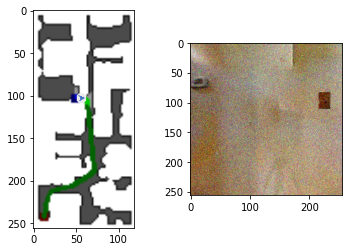

In [22]:
ti = time.time()
for i in range(1):
    
    step_observation = {k: v[rollouts.step] for k, v in rollouts.observations.items()}
    
    #print(rollouts.prev_actions[rollouts.step])
    #print(rollouts.masks[rollouts.step])
    (values, actions, actions_log_probs, recurrent_hidden_states) = actor_critic.act(
                step_observation,
                rollouts.recurrent_hidden_states[rollouts.step],
                rollouts.prev_actions[rollouts.step],
                rollouts.masks[rollouts.step])
    #print('Action: ',actions.item(),actions_log_probs.item(),values.item())
    best_action = follower.get_next_action(one_env.habitat_env.current_episode.goals[0].position)
    observations, rewards, dones, infos = one_env.step(action=best_action)#actions.item())

    batch = batch_obs([observations])
    rewards = torch.tensor(rewards, dtype=torch.float, device=device)
    #rewards = rewards.unsqueeze(1)
    masks = torch.tensor(
            [[0.0] if dones else [1.0]],
            dtype=torch.float,
            device=device)
    rollouts.insert(
            batch,
            recurrent_hidden_states,
            actions,
            actions_log_probs,
            values,
            rewards,
            masks)
    r+=rewards
me = time.time()
print(me-ti)
print('Pointgoal','\t',one_env.obs['pointgoal'][[0,2]])
print('Pointg+gp','\t',one_env.obs['pointgoal_with_gps_compass'][[0,2]])
print('Agent_Pos','\t',one_env.obs['agent_position'][0][[0,2]])
print('Truee_X_Y','\t',[one_env.trux,one_env.truy])
print('Goaal_X_Y','\t',[one_env.goalx,one_env.goaly])
print(observations['pos'])
top_down_map = draw_top_down_map(infos, one_env.obs["heading"][0], one_env.obs['rgb'][0].shape[0])
plt.subplot(1, 2, 1)
plt.imshow(top_down_map)
plt.subplot(1, 2, 2)
plt.imshow(observations['rgb'])

In [369]:
prev_compas = one_env.obs['compass']
one_env.step(action=3)
curr_compas = one_env.obs['compass']
df = curr_compas - prev_compas
if abs(df) > np.pi:
    if curr_compas > prev_compas:
        df = curr_compas - prev_compas - 2 * np.pi
    else:
        df = curr_compas - prev_compas + 2 * np.pi    
print(df,prev_compas,curr_compas,one_env.obs['compass'])        
#one_env.obs['compass']

[-0.18346214] [0.5126654] [0.32920325] [0.32920325]


## EVALUATE

In [10]:
from gym.spaces.box import Box
from resnet_policy import PointNavResNetPolicy
from habitat_baselines.common.rollout_storage import RolloutStorage
import transformations as tf
from habitat_baselines.common.utils import batch_obs, linear_decay
import argparse
import habitat
import random
import numpy as np
from scipy.spatial.transform import Rotation as R
import torch
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [11]:
!mkdir /habitat-challenge-data
!cp /data/challenge_pointnav2020.local.rgbd.yaml /habitat-challenge-data/challenge_pointnav2020.local.rgbd.yaml

mkdir: cannot create directory ‘/habitat-challenge-data’: File exists


In [11]:
parser = argparse.ArgumentParser()
parser.add_argument("--evaluation", type=str, required=False, choices=["local", "remote"], default="local")
args = parser.parse_args('')

In [12]:
from typing import Any, Dict, Iterator, List, Optional, Tuple, Type, Union
import gym
import numba
import numpy as np
from gym.spaces.dict_space import Dict as SpaceDict
from habitat.config import Config
from habitat.core.dataset import Dataset, Episode, EpisodeIterator
from habitat.core.embodied_task import EmbodiedTask, Metrics
from habitat.core.simulator import Observations, Simulator
from habitat.datasets import make_dataset
from habitat.sims import make_sim
from habitat.tasks import make_task

class Env:

    observation_space: SpaceDict
    action_space: SpaceDict
    _config: Config
    _dataset: Optional[Dataset]
    number_of_episodes: Optional[int]
    _episodes: List[Type[Episode]]
    _current_episode_index: Optional[int]
    _current_episode: Optional[Type[Episode]]
    _episode_iterator: Optional[Iterator]
    _sim: Simulator
    _task: EmbodiedTask
    _max_episode_seconds: int
    _max_episode_steps: int
    _elapsed_steps: int
    _episode_start_time: Optional[float]
    _episode_over: bool

    def __init__(
        self, config: Config, dataset: Optional[Dataset] = None
    ) -> None:

        assert config.is_frozen(), (
            "Freeze the config before creating the "
            "environment, use config.freeze().")
        self._config = config
        self._dataset = dataset
        self._current_episode_index = None
        if self._dataset is None and config.DATASET.TYPE:
            self._dataset = make_dataset(
                id_dataset=config.DATASET.TYPE, config=config.DATASET
            )
        self._episodes = self._dataset.episodes if self._dataset else []
        self._current_episode = None
        iter_option_dict = {
            k.lower(): v
            for k, v in config.ENVIRONMENT.ITERATOR_OPTIONS.items()
        }
        self._episode_iterator = self._dataset.get_episode_iterator(
            **iter_option_dict
        )

        # load the first scene if dataset is present
        if self._dataset:
            assert (
                len(self._dataset.episodes) > 0
            ), "dataset should have non-empty episodes list"
            self._config.defrost()
            self._config.SIMULATOR.SCENE = self._dataset.episodes[0].scene_id
            self._config.freeze()

            self.number_of_episodes = len(self._dataset.episodes)
        else:
            self.number_of_episodes = None

        self._sim = make_sim(
            id_sim=self._config.SIMULATOR.TYPE, config=self._config.SIMULATOR)
        self._task = make_task(
            self._config.TASK.TYPE,
            config=self._config.TASK,
            sim=self._sim,
            dataset=self._dataset)
        self.observation_space = SpaceDict(
            {
                **self._sim.sensor_suite.observation_spaces.spaces,
                **self._task.sensor_suite.observation_spaces.spaces,
            })
        self.action_space = self._task.action_space
        self._max_episode_seconds = (
            self._config.ENVIRONMENT.MAX_EPISODE_SECONDS)
        self._max_episode_steps = self._config.ENVIRONMENT.MAX_EPISODE_STEPS
        self._elapsed_steps = 0
        self._episode_start_time: Optional[float] = None
        self._episode_over = False

    @property
    def current_episode(self) -> Type[Episode]:
        assert self._current_episode is not None
        return self._current_episode

    @current_episode.setter
    def current_episode(self, episode: Type[Episode]) -> None:
        self._current_episode = episode

    @property
    def episode_iterator(self) -> Iterator:
        return self._episode_iterator

    @episode_iterator.setter
    def episode_iterator(self, new_iter: Iterator) -> None:
        self._episode_iterator = new_iter

    @property
    def episodes(self) -> List[Type[Episode]]:
        return self._episodes

    @episodes.setter
    def episodes(self, episodes: List[Type[Episode]]) -> None:
        assert (
            len(episodes) > 0
        ), "Environment doesn't accept empty episodes list."
        self._episodes = episodes

    @property
    def sim(self) -> Simulator:
        return self._sim

    @property
    def episode_start_time(self) -> Optional[float]:
        return self._episode_start_time

    @property
    def episode_over(self) -> bool:
        return self._episode_over

    @property
    def task(self) -> EmbodiedTask:
        return self._task

    @property
    def _elapsed_seconds(self) -> float:
        assert (
            self._episode_start_time
        ), "Elapsed seconds requested before episode was started."
        return time.time() - self._episode_start_time

    def get_metrics(self) -> Metrics:
        return self._task.measurements.get_metrics()

    def _past_limit(self) -> bool:
        if (
            self._max_episode_steps != 0
            and self._max_episode_steps <= self._elapsed_steps
        ):
            return True
        elif (
            self._max_episode_seconds != 0
            and self._max_episode_seconds <= self._elapsed_seconds
        ):
            return True
        return False

    def _reset_stats(self) -> None:
        self._episode_start_time = time.time()
        self._elapsed_steps = 0
        self._episode_over = False

    def reset(self) -> Observations:
        r"""Resets the environments and returns the initial observations.
        :return: initial observations from the environment.
        """
        self._reset_stats()

        assert len(self.episodes) > 0, "Episodes list is empty"
        if self._current_episode is not None:
            self._current_episode._shortest_path_cache = None

        # Delete the shortest path cache of the current episode
        # Caching it for the next time we see this episode isn't really worth
        # it
        if self._current_episode is not None:
            self._current_episode._shortest_path_cache = None

        self._current_episode = next(self._episode_iterator)
        self.reconfigure(self._config)

        observations = self.task.reset(episode=self.current_episode)
        self._task.measurements.reset_measures(
            episode=self.current_episode, task=self.task)

        return observations

    def _update_step_stats(self) -> None:
        self._elapsed_steps += 1
        self._episode_over = not self._task.is_episode_active
        if self._past_limit():
            self._episode_over = True

        if self.episode_iterator is not None and isinstance(
            self.episode_iterator, EpisodeIterator):
            self.episode_iterator.step_taken()

    def step(
        self, action: Union[int, str, Dict[str, Any]], **kwargs) -> Observations:

        assert (
            self._episode_start_time is not None
        ), "Cannot call step before calling reset"
        assert (
            self._episode_over is False
        ), "Episode over, call reset before calling step"
        # Support simpler interface as well
        if isinstance(action, str) or isinstance(action, (int, np.integer)):
            action = {"action": action}
            
        for i in range(20):    
            observations = self.task.step(action=action, episode=self.current_episode)
            if done:
                break 
        self._task.measurements.update_measures(
            episode=self.current_episode, action=action, task=self.task)
        self._update_step_stats()
        return observations

    @staticmethod
    @numba.njit
    def _seed_numba(seed: int):
        random.seed(seed)
        np.random.seed(seed)

    def seed(self, seed: int) -> None:
        random.seed(seed)
        np.random.seed(seed)
        self._seed_numba(seed)
        self._sim.seed(seed)
        self._task.seed(seed)

    def reconfigure(self, config: Config) -> None:
        self._config = config
        self._config.defrost()
        self._config.SIMULATOR = self._task.overwrite_sim_config(
            self._config.SIMULATOR, self.current_episode)
        self._config.freeze()
        self._sim.reconfigure(self._config.SIMULATOR)

    def render(self, mode="rgb") -> np.ndarray:
        return self._sim.render(mode)

    def close(self) -> None:
        self._sim.close()

In [13]:
from habitat.core.logging import logger
from collections import defaultdict
from typing import Dict, Optional

from habitat.config.default import get_config
from habitat.core.agent import Agent
from habitat.core.env import Env

class Benchmark:
    r"""Benchmark for evaluating agents in environments.
    """

    def __init__(
        self, config_paths: Optional[str] = None, eval_remote=False
    ) -> None:
        r"""..

        :param config_paths: file to be used for creating the environment
        :param eval_remote: boolean indicating whether evaluation should be run remotely or locally
        """
        config_env = get_config(config_paths)
        config_env.defrost()
        config_env.TASK.AGENT_POSITION_SENSOR = habitat.Config()
        config_env.TASK.AGENT_POSITION_SENSOR.TYPE = "position_sensor"
        config_env.TASK.AGENT_POSITION_SENSOR.ANSWER_TO_LIFE = 42
        config_env.TASK.SENSORS.append("AGENT_POSITION_SENSOR")
        config_env.SIMULATOR.TURN_ANGLE = 0.5
        config_env.SIMULATOR.TILT_ANGLE = 0.5
        config_env.SIMULATOR.FORWARD_STEP_SIZE = 0.0125
        config_env.ENVIRONMENT.MAX_EPISODE_STEPS = 500*20
        config_env.TASK.TOP_DOWN_MAP.MAX_EPISODE_STEPS = 500*20
        config_env.freeze()
        self._eval_remote = eval_remote
        
        

        if self._eval_remote is True:
            self._env = None
        else:
            self._env = Env(config=config_env)
            self._env.seed(0)

    def remote_evaluate(
        self, agent: Agent, num_episodes: Optional[int] = None
    ):
        # The modules imported below are specific to habitat-challenge remote evaluation.
        # These modules are not part of the habitat-api repository.
        import evaluation_pb2
        import evaluation_pb2_grpc
        import evalai_environment_habitat
        import grpc
        import pickle
        import time

        time.sleep(60)

        def pack_for_grpc(entity):
            return pickle.dumps(entity)

        def unpack_for_grpc(entity):
            return pickle.loads(entity)

        def remote_ep_over(stub):
            res_env = unpack_for_grpc(
                stub.episode_over(evaluation_pb2.Package()).SerializedEntity
            )
            return res_env["episode_over"]

        channel = grpc.insecure_channel("localhost:8085")
        stub = evaluation_pb2_grpc.EnvironmentStub(channel)

        base_num_episodes = unpack_for_grpc(
            stub.num_episodes(evaluation_pb2.Package()).SerializedEntity
        )
        num_episodes = base_num_episodes["num_episodes"]

        agg_metrics: Dict = defaultdict(float)
        count_episodes = 0

        while count_episodes < num_episodes:
            logger.info("Current Episode: {}".format(count_episodes))
            agent.reset()
            res_env = unpack_for_grpc(
                stub.reset(evaluation_pb2.Package()).SerializedEntity
            )
            obs = res_env["observations"]

            while not remote_ep_over(stub):
                action = agent.act(obs)

                res_env = unpack_for_grpc(
                    stub.act_on_environment(
                        evaluation_pb2.Package(
                            SerializedEntity=pack_for_grpc(action)
                        )
                    ).SerializedEntity
                )

            metrics = unpack_for_grpc(
                stub.get_metrics(
                    evaluation_pb2.Package(
                        SerializedEntity=pack_for_grpc(action)
                    )
                    ).SerializedEntity
                )

            metrics = unpack_for_grpc(
                stub.get_metrics(
                    evaluation_pb2.Package(
                        SerializedEntity=pack_for_grpc(action)
                    )
                ).SerializedEntity
            )

            for m, v in metrics["metrics"].items():
                agg_metrics[m] += v
            count_episodes += 1

        avg_metrics = {k: v / count_episodes for k, v in agg_metrics.items()}

        stub.evalai_update_submission(evaluation_pb2.Package())

        return avg_metrics

    def local_evaluate(self, agent: Agent, num_episodes: Optional[int] = None):
        if num_episodes is None:
            num_episodes = len(self._env.episodes)
        else:
            assert num_episodes <= len(self._env.episodes), (
                "num_episodes({}) is larger than number of episodes "
                "in environment ({})".format(
                    num_episodes, len(self._env.episodes)
                )
            )

        assert num_episodes > 0, "num_episodes should be greater than 0"
        agg_metrics: Dict = defaultdict(float)

        count_episodes = 0
        while count_episodes < num_episodes:
            agent.reset()
            observations = self._env.reset()

            while not self._env.episode_over:
                action = agent.act(observations)
                observations = self._env.step(action)

            metrics = self._env.get_metrics()
            for m, v in metrics.items():
                agg_metrics[m] += v
            count_episodes += 1

        avg_metrics = {k: v / count_episodes for k, v in agg_metrics.items()}

        return avg_metrics

    def evaluate(
        self, agent: Agent, num_episodes: Optional[int] = None
    ) -> Dict[str, float]:
        r"""..

        :param agent: agent to be evaluated in environment.
        :param num_episodes: count of number of episodes for which the
            evaluation should be run.
        :return: dict containing metrics tracked by environment.
        """

        if self._eval_remote is True:
            return self.remote_evaluate(agent, num_episodes)
        else:
            return self.local_evaluate(agent, num_episodes)
                    

class Challenge(Benchmark):
    def __init__(self, eval_remote=False):
        config_paths = os.environ["CHALLENGE_CONFIG_FILE"]
        super().__init__(config_paths, eval_remote=eval_remote)

    def submit(self, agent):
        metrics = super().evaluate(agent)
        for k, v in metrics.items():
            logger.info("{}: {}".format(k, v))

In [14]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [15]:
from utils import AgentPositionSensor,draw_top_down_map,inverse_transform,make_train_data,RewardForwardFilter,RunningMeanStd,global_grad_norm_
class RandomAgent(habitat.Agent):
    def __init__(self, task_config: habitat.Config):
        self._POSSIBLE_ACTIONS = task_config.TASK.POSSIBLE_ACTIONS
        self.trux = 0; self.truy = 0; self.truz = 0
        self.goalx = 0; self.goaly = 0
        self.xdif = 0; self.ydif = 0
        
        self.obs_space = dotdict()
        self.obs_space.spaces = {}
        self.obs_space.spaces['depth'] = Box(low=-1000, high=1000, shape=(256,256,1), dtype=np.float32)
        self.obs_space.spaces['rgb'] = Box(low=-1000, high=1000, shape=(256,256,3), dtype=np.float32)
        self.obs_space.spaces['pos'] = Box(low=-1000, high=1000, shape=(2,), dtype=np.float32)

        self.act_space = dotdict()
        self.act_space.n = 4
        self.act_space.shape = [1]
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.actor_critic = PointNavResNetPolicy(
            observation_space=self.obs_space,
            action_space=self.act_space,
            hidden_size=512,
            rnn_type='LSTM',
            num_recurrent_layers=2,
            backbone='resnet50',
            goal_sensor_uuid='pos',
            normalize_visual_inputs=False,
        )
        self.actor_critic.to(self.device);
        
        pretrained_state = torch.load('ckpt.143.pth', map_location="cpu")
        self.actor_critic.load_state_dict({k[len("actor_critic.") :]: v for k, v in pretrained_state["state_dict"].items() if "actor_critic" in k})
        self.step = 0
        
        
    def reset(self):
        self.step = 0
        self.rollouts = RolloutStorage(
            500,
            1,
            self.obs_space,
            self.act_space,
            512,
            num_recurrent_layers=self.actor_critic.net.num_recurrent_layers)
        self.rollouts.to(self.device)
        self.trux = 0; self.truy = 0
        print('RESET')
        

    def act(self, observations):
        if self.step==0:
            self.vector = np.array([0., 0., 0.])
            self.vector1 = np.array([0.25, 0., 0.])
            self.r = R.from_rotvec([0, 0, 0])
            self.r2 = R.from_rotvec([0, -np.pi/9, 0])
            self.r3 = R.from_rotvec([0, np.pi/9, 0])
            xx,yy = observations['pointgoal']
            self.is_started = False
            self.goalx, self.goaly = inverse_transform(yy, xx, 0, 0, np.pi)
            #self.publish_true_path(observations['agent_position'])
            self.xdif,self.ydif = self.trux-self.goalx, self.truy-self.goaly
            observations['pos'] = [self.xdif,self.ydif]
            del observations['agent_position']
            batch = batch_obs([observations])
            for sensor in self.rollouts.observations:
                self.rollouts.observations[sensor][0].copy_(batch[sensor])
        else:
            #self.publish_true_path(observations['agent_position'])
            self.trux,self.truy = self.vector[0], self.vector[2]
            self.xdif,self.ydif = self.trux-self.goalx, self.truy-self.goaly
            observations['pos'] = [self.xdif,self.ydif]
            del observations['agent_position']
            del observations['pointgoal']
            
            batch = batch_obs([observations])
            rewards = torch.tensor(0, dtype=torch.float, device=self.device)
            masks = torch.tensor([[1.0]],dtype=torch.float,device=self.device)
            self.rollouts.insert(batch,self.recurrent_hidden_states,self.actions,
                            self.actions_log_probs,self.values,rewards,masks)
            
        self.step+=1
        # rgb depth pointgoal
        step_observation = {k: v[self.rollouts.step] for k, v in self.rollouts.observations.items()}
        #print('\t',self.rollouts.prev_actions[self.rollouts.step],self.rollouts.step)
        
        
        (self.values, self.actions, self.actions_log_probs, self.recurrent_hidden_states) = self.actor_critic.act(
                step_observation,
                self.rollouts.recurrent_hidden_states[self.rollouts.step],
                self.rollouts.prev_actions[self.rollouts.step],
                self.rollouts.masks[self.rollouts.step])
        
        #print(self.actions.item())
        
        act = self.actions.item()
        #act = np.random.choice(self._POSSIBLE_ACTIONS)}

        if act==1:
            self.vector+=self.r.apply(self.vector1)
        if act==2:
            self.r = self.r*self.r2
        if act==3:
            self.r = self.r*self.r3
        #print(self.vector, [self.trux,self.truy])    
        #print((self.r).as_euler('xyz', degrees=True))   
        
        return {"action": act}
    
    
    
    def publish_true_path(self, pose):

        position, rotation = pose
        y, z, x = position
        cur_orientation = rotation
        cur_euler_angles = tf.euler_from_quaternion([cur_orientation.w, cur_orientation.x, cur_orientation.z, cur_orientation.y])
        cur_x_angle, cur_y_angle, cur_z_angle = cur_euler_angles
        cur_z_angle += np.pi

        if not self.is_started:
            self.is_started = True
            self.slam_start_angle = cur_z_angle
            self.slam_start_x = x
            self.slam_start_y = y
            self.slam_start_z = z
        # if SLAM is running, transform global coords to RViz coords
        rviz_x, rviz_y = inverse_transform(x, y, self.slam_start_x, self.slam_start_y, self.slam_start_angle)
        rviz_z = z - self.slam_start_z
        cur_quaternion = tf.quaternion_from_euler(0, 0, cur_z_angle - self.slam_start_angle)
        cur_orientation.w = cur_quaternion[0]
        cur_orientation.x = cur_quaternion[1]
        cur_orientation.y = cur_quaternion[2]
        cur_orientation.z = cur_quaternion[3]
        x, y, z = rviz_x, rviz_y, rviz_z
        self.trux = x; self.truy = y; self.truz = z;  

In [16]:
challenge = Challenge(eval_remote=False)

2020-05-02 22:24:53,502 Initializing dataset PointNav-v1
2020-05-02 22:24:53,507 initializing sim Sim-v0
2020-05-02 22:24:55,158 Initializing task Nav-v0


In [19]:
challenge._env.reset()

{'rgb': array([[[126, 133, 163],
         [117, 199, 158],
         [133, 142, 151],
         ...,
         [130, 143, 128],
         [119, 166, 168],
         [157, 180, 150]],
 
        [[113, 139, 123],
         [154, 179, 130],
         [158, 167, 150],
         ...,
         [191, 106, 163],
         [130, 171, 169],
         [153, 139, 176]],
 
        [[113, 156, 157],
         [140, 184, 168],
         [123, 153, 156],
         ...,
         [141, 189, 195],
         [147, 176, 176],
         [161, 201, 185]],
 
        ...,
 
        [[ 67, 184, 144],
         [107,  89, 142],
         [147, 111, 109],
         ...,
         [184, 212, 177],
         [197, 206, 177],
         [162, 167, 195]],
 
        [[123, 170,  99],
         [112, 127, 115],
         [121, 121,  95],
         ...,
         [173, 237, 170],
         [157, 175, 140],
         [166, 160, 208]],
 
        [[150, 158, 139],
         [105, 162, 113],
         [128, 118,  48],
         ...,
         [140, 204, 1

In [186]:
config_env = get_config(os.environ["CHALLENGE_CONFIG_FILE"])
agent = RandomAgent(task_config=config_env)

In [ ]:
challenge.submit(agent)

RESET


In [8]:
config_env = get_config(os.environ["CHALLENGE_CONFIG_FILE"])

Config({'SEED': 100, 'ENVIRONMENT': Config({'MAX_EPISODE_STEPS': 500, 'MAX_EPISODE_SECONDS': 10000000, 'ITERATOR_OPTIONS': Config({'CYCLE': True, 'SHUFFLE': False, 'GROUP_BY_SCENE': True, 'NUM_EPISODE_SAMPLE': -1, 'MAX_SCENE_REPEAT_EPISODES': -1, 'MAX_SCENE_REPEAT_STEPS': 10000, 'STEP_REPETITION_RANGE': 0.2})}), 'TASK': Config({'TYPE': 'Nav-v0', 'SUCCESS_DISTANCE': 0.36, 'SENSORS': ['POINTGOAL_SENSOR'], 'MEASUREMENTS': ['DISTANCE_TO_GOAL', 'SUCCESS', 'SPL'], 'GOAL_SENSOR_UUID': 'pointgoal', 'POSSIBLE_ACTIONS': ['STOP', 'MOVE_FORWARD', 'TURN_LEFT', 'TURN_RIGHT'], 'ACTIONS': Config({'STOP': Config({'TYPE': 'StopAction'}), 'MOVE_FORWARD': Config({'TYPE': 'MoveForwardAction'}), 'TURN_LEFT': Config({'TYPE': 'TurnLeftAction'}), 'TURN_RIGHT': Config({'TYPE': 'TurnRightAction'}), 'LOOK_UP': Config({'TYPE': 'LookUpAction'}), 'LOOK_DOWN': Config({'TYPE': 'LookDownAction'}), 'TELEPORT': Config({'TYPE': 'TeleportAction'}), 'ANSWER': Config({'TYPE': 'AnswerAction'})}), 'POINTGOAL_SENSOR': Config({'

In [ ]:
2020-04-28 18:32:02,004 distance_to_goal: 2.920840401450793
2020-04-28 18:32:02,006 success: 0.03333333333333333
2020-04-28 18:32:02,007 spl: 0.010942113252719475
            
2020-04-28 18:55:30,074 distance_to_goal: 2.937317087252935
2020-04-28 18:55:30,075 success: 0.06666666666666667
2020-04-28 18:55:30,075 spl: 0.03299149653561261            

In [126]:
from scipy.spatial.transform import Rotation as R

In [127]:
vector = np.array([0., 0., 0.])
vector1 = np.array([0.25, 0., 0.])
r = R.from_rotvec([0, 0, 0])
r2 = R.from_rotvec([0, np.pi/9, 0])
r3 = R.from_rotvec([0, -np.pi/9, 0])

In [148]:
d = 1
if d==1:
    vector+=r.apply(vector1)
if d==2:
    r = r*r2
if d==3:
    r = r*r3
print(vector)    
print((r).as_euler('xyz', degrees=True))    

[ 3.87266666  0.         -2.41045354]
[ 0. 40.  0.]


In [90]:
r.apply(vector1)

array([0.25, 0.  , 0.  ])

In [52]:
np.array([0,1,0])*r

TypeError: unsupported operand type(s) for *: 'int' and 'Rotation'

In [46]:
(r).as_euler('xyz', degrees=True)

array([ 0.,  0., 20.])

In [37]:
(r*r).as_euler('xyz', degrees=True)

array([ 0.,  0., 60.])

In [40]:
from pyquaternion import Quaternion

In [47]:
q1 = Quaternion(axis=[1., 0., 0.], angle=np.pi/9)

In [49]:
q1.normalised

Quaternion(0.984807753012208, 0.17364817766693033, 0.0, 0.0)